# Processing the electron-phonon collision matrix

This is meant to be a frills-free calculation of the electron-phonon collision matrix utiizing the data from Jin Jian Zhou for GaAs.

## Package imports

In [1]:
import numpy as np

# Image processing tools
import skimage
import skimage.filters

import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba
import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from numpy.linalg import inv

from tqdm import tqdm, trange
from scipy import special, optimize
from scipy import integrate

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
#plotly.tools.set_credentials_file(username='AYChoi', api_key='ZacDa7fKo8hfiELPfs57')
plotly.tools.set_credentials_file(username='AlexanderYChoi', api_key='VyLt05wzc89iXwSC82FO')

## Data processing

Take the raw text files and convert them into useful dataframes.

In [2]:
# Physical parameter definition
a = 5.556                        # Lattice constant for GaAs [A]
kb = 1.38064852*10**(-23)        # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
T = 300                          # Lattice temeprature [K]
e = 1.602*10**(-19)              # Fundamental electronic charge [C]
mu = 5.780                       # Chemical potential [eV]
b = 8/1000                       # Gaussian broadening [eV]

In [124]:
data = pd.read_csv('gaas.eph_matrix', sep='\t',header= None,skiprows=(0,1))
data.columns = ['0']
data_array = data['0'].values
new_array = np.zeros((len(data_array),7))
for i1 in trange(len(data_array)):
    new_array[i1,:] = data_array[i1].split()
    
g_df = pd.DataFrame(data=new_array,columns = ['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element'])
g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode']] = g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode']].apply(pd.to_numeric,downcast = 'integer')


g_df = g_df.drop(["m_band","n_band"],axis=1)

100%|████████████████████████████████████████████████████████████████████| 7854608/7854608 [00:33<00:00, 237802.16it/s]


In [4]:
# Import electron energy library
enk = pd.read_csv('gaas.enk', sep='\t',header= None)
enk.columns = ['0']
enk_array = enk['0'].values
new_enk_array = np.zeros((len(enk_array),3))
for i1 in trange(len(enk_array)):
    new_enk_array[i1,:] = enk_array[i1].split()
    
enk_df = pd.DataFrame(data=new_enk_array,columns = ['k_inds','band_inds','energy [Ryd]'])
enk_df[['k_inds','band_inds']] = enk_df[['k_inds','band_inds']].apply(pd.to_numeric,downcast = 'integer')
enk_df = enk_df.drop(['band_inds'],axis=1)

# Import phonon energy library
enq = pd.read_csv('gaas.enq', sep='\t',header= None)
enq.columns = ['0']
enq_array = enq['0'].values
new_enq_array = np.zeros((len(enq_array),3))
for i1 in trange(len(enq_array)):
    new_enq_array[i1,:] = enq_array[i1].split()
    
enq_df = pd.DataFrame(data=new_enq_array,columns = ['q_inds','im_mode','energy [Ryd]'])
enq_df[['q_inds','im_mode']] = enq_df[['q_inds','im_mode']].apply(pd.to_numeric,downcast = 'integer')


# Import phonon q-point index
qpts = pd.read_csv('gaas.qpts', sep='\t',header= None)
qpts.columns = ['0']
qpts_array = qpts['0'].values
new_qpt_array = np.zeros((len(qpts_array),4))

for i1 in trange(len(qpts_array)):
    new_qpt_array[i1,:] = qpts_array[i1].split()
    
qpts_df = pd.DataFrame(data=new_qpt_array,columns = ['q_inds','b1','b2','b3'])
qpts_df[['q_inds']] = qpts_df[['q_inds']].apply(pd.to_numeric,downcast = 'integer')

100%|████████████████████████████████████████████████████████████████████████| 21080/21080 [00:00<00:00, 325178.11it/s]


In [5]:
# Import electron k-point index and group velocities

kvel = pd.read_csv('gaas.vel', sep='\t',header= None,skiprows=[0,1,2])
kvel.columns = ['0']
kvel_array = kvel['0'].values
new_kvel_array = np.zeros((len(kvel_array),10))
for i1 in trange(len(kvel_array)):
    new_kvel_array[i1,:] = kvel_array[i1].split()
    
kvel_df = pd.DataFrame(data=new_kvel_array,columns = ['k_inds','bands','energy','kx [2pi/alat]','ky [2pi/alat]','kz [2pi/alat]','vx_dir','vy_dir','vz_dir','v_mag [m/s]'])
kvel_df[['k_inds']] = kvel_df[['k_inds']].apply(pd.to_numeric,downcast = 'integer')

kvel_edit = kvel_df.copy(deep=True)

# Shift the points back into the first BZ
kx_plus = kvel_df['kx [2pi/alat]'] > 0.5
kx_minus = kvel_df['kx [2pi/alat]'] < -0.5

ky_plus = kvel_df['ky [2pi/alat]'] > 0.5
ky_minus = kvel_df['ky [2pi/alat]'] < -0.5

kz_plus = kvel_df['kz [2pi/alat]'] > 0.5
kz_minus = kvel_df['kz [2pi/alat]'] < -0.5

kvel_edit.loc[kx_plus,'kx [2pi/alat]'] = kvel_df.loc[kx_plus,'kx [2pi/alat]'] -1
kvel_edit.loc[kx_minus,'kx [2pi/alat]'] = kvel_df.loc[kx_minus,'kx [2pi/alat]'] +1

kvel_edit.loc[ky_plus,'ky [2pi/alat]'] = kvel_df.loc[ky_plus,'ky [2pi/alat]'] -1
kvel_edit.loc[ky_minus,'ky [2pi/alat]'] = kvel_df.loc[ky_minus,'ky [2pi/alat]'] +1

kvel_edit.loc[kz_plus,'kz [2pi/alat]'] = kvel_df.loc[kz_plus,'kz [2pi/alat]'] -1
kvel_edit.loc[kz_minus,'kz [2pi/alat]'] = kvel_df.loc[kz_minus,'kz [2pi/alat]'] +1

kvel_df = kvel_edit.copy(deep=True)
kvel_df.head()

cart_kpts_df = kvel_df.copy(deep=True)
cart_kpts_df['kx [2pi/alat]'] = cart_kpts_df['kx [2pi/alat]'].values*2*np.pi/a
cart_kpts_df['ky [2pi/alat]'] = cart_kpts_df['ky [2pi/alat]'].values*2*np.pi/a
cart_kpts_df['kz [2pi/alat]'] = cart_kpts_df['kz [2pi/alat]'].values*2*np.pi/a

cart_kpts_df.columns = ['k_inds', 'bands', 'energy', 'kx [1/A]', 'ky [1/A]','kz [1/A]', 'vx_dir', 'vy_dir', 'vz_dir', 'v_mag [m/s]']

cart_kpts_df  = cart_kpts_df.drop(['bands'],axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 2213/2213 [00:00<00:00, 184918.71it/s]


In [92]:
def fermi_distribution(g_df,mu,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        ...
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
         
    """
    # Physical constants    
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]


    g_df['k_FD'] = (np.exp((g_df['k_en [eV]'].values*e - mu*e)/(kb*T)) + 1)**(-1)
    g_df['k+q_FD'] = (np.exp((g_df['k+q_en [eV]'].values*e - mu*e)/(kb*T)) + 1)**(-1)

    return g_df


def bose_distribution(g_df,T):
    """
    This function takes a list of q-point indices and returns the Bose-Einstein distributions associated with each q-point on that list.    
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        ...
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        ...
        
        BE : vector_like, shape (n,1)
        Bose-einstein distribution
         
    """
    # Physical constants    
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]

    g_df['BE'] = (np.exp((g_df['q_en [eV]'].values*e)/(kb*T)) - 1)**(-1)
    return g_df


def bosonic_processing(g_df,enq_df,T):
    """
    This function takes the g dataframe and assigns a phonon energy from the relevant phonon library to each collision and the appropriate Bose-Einstein distribution.
    -----------
    
    g_df : pandas dataframe containing:
    
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:
    
    ...
        BE : vector_like, shape (n,1)
        Bose-Einstein distribution of the phonon mediating a collision
        
        q_en [eV] : vector_like, shape (n,1)
        The energy of the phonon mode mediating a collision
         
    """
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    modified_g_df = g_df.copy(deep=True)
    modified_g_df.set_index(['q_inds', 'im_mode'], inplace=True)
    modified_g_df = modified_g_df.sort_index()
    modified_enq_df = enq_df.copy(deep=True)
    modified_enq_df.set_index(['q_inds', 'im_mode'], inplace=True)
    modified_enq_df = modified_enq_df.sort_index()
    modified_enq_df = modified_enq_df.loc[modified_g_df.index.unique()]
    
    modified_enq_df = modified_enq_df.reset_index()
    modified_enq_df = modified_enq_df.sort_values(['q_inds','im_mode'],ascending=True)
    modified_enq_df = modified_enq_df[['q_inds','im_mode','energy [Ryd]']]
    modified_enq_df['q_id'] = modified_enq_df.groupby(['q_inds','im_mode']).ngroup()
    g_df['q_id'] = g_df.sort_values(['q_inds','im_mode'],ascending=True).groupby(['q_inds','im_mode']).ngroup()
    
    g_df['q_en [eV]'] = modified_enq_df['energy [Ryd]'].values[g_df['q_id'].values]*13.6056980659
    
    g_df = bose_distribution(g_df,T)
    
    return g_df


def fermionic_processing(g_df,cart_kpts_df,mu,T,b):
    """
    This function takes the g dataframe and assigns an electron energy from the relevant electron library to the pre and post collision states and the appropriate Fermi-Diract distributions.
    -----------
    
    g_df : pandas dataframe containing:
    
    ...
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:
    
    ...
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
         
    """

    # Pre-collision
    modified_g_df_k = g_df.copy(deep=True)
    modified_g_df_k.set_index(['k_inds'], inplace=True)
    modified_g_df_k = modified_g_df_k.sort_index()

    modified_k_df = cart_kpts_df.copy(deep=True)
    modified_k_df.set_index(['k_inds'], inplace=True)
    modified_k_df = modified_k_df.sort_index()
    modified_k_df = modified_k_df.loc[modified_g_df_k.index.unique()]
    
    modified_k_df = modified_k_df.reset_index()
    modified_k_df = modified_k_df.sort_values(['k_inds'],ascending=True)
    modified_k_df = modified_k_df[['k_inds','energy','kx [1/A]','ky [1/A]','kz [1/A]']]
    
    modified_k_df['k_id'] = modified_k_df.groupby(['k_inds']).ngroup()
    g_df['k_id'] = g_df.sort_values(['k_inds'],ascending=True).groupby(['k_inds']).ngroup()   
    g_df['k_en [eV]'] = modified_k_df['energy'].values[g_df['k_id'].values]
    
    g_df['kx [1/A]'] = modified_k_df['kx [1/A]'].values[g_df['k_id'].values]
    g_df['ky [1/A]'] = modified_k_df['ky [1/A]'].values[g_df['k_id'].values]
    g_df['kz [1/A]'] = modified_k_df['kz [1/A]'].values[g_df['k_id'].values]

    
    # Post-collision
    modified_g_df_kq = g_df.copy(deep=True)
    modified_g_df_kq.set_index(['k_inds'], inplace=True)
    modified_g_df_kq = modified_g_df_kq.sort_index()
    
    modified_k_df = cart_kpts_df.copy(deep=True)
    modified_k_df.set_index(['k_inds'], inplace=True)
    modified_k_df = modified_k_df.sort_index()
    modified_k_df = modified_k_df.loc[modified_g_df_kq.index.unique()]
    
    modified_k_df = modified_k_df.reset_index()
    modified_k_df = modified_k_df.sort_values(['k_inds'],ascending=True)
    modified_k_df = modified_k_df[['k_inds','energy','kx [1/A]','ky [1/A]','kz [1/A]']]
    
    modified_k_df['k+q_id'] = modified_k_df.groupby(['k_inds']).ngroup()
    g_df['k+q_id'] = g_df.sort_values(['k+q_inds'],ascending=True).groupby(['k+q_inds']).ngroup()   
    g_df['k+q_en [eV]'] = modified_k_df['energy'].values[g_df['k+q_id'].values]
    
    g_df['kqx [1/A]'] = modified_k_df['kx [1/A]'].values[g_df['k+q_id'].values]
    g_df['kqy [1/A]'] = modified_k_df['ky [1/A]'].values[g_df['k+q_id'].values]
    g_df['kqz [1/A]'] = modified_k_df['kz [1/A]'].values[g_df['k+q_id'].values]

    
    abs_inds = g_df['k_en [eV]'] < g_df['k+q_en [eV]'] #absorbed indices
    ems_inds = g_df['k_en [eV]'] > g_df['k+q_en [eV]'] #emission indices

    
    g_df.loc[abs_inds,'collision_state'] = 1
    g_df.loc[ems_inds,'collision_state'] = -1
    
    g_df = fermi_distribution(g_df,mu, T)
    
    g_df = g_df.drop(['k_id','k+q_id'],axis=1)
    
    g_df = gaussian_weight(g_df,b)
    
    return g_df

def gaussian_weight(g_df,n):
    """
    This function assigns the value of the delta function approximated by a Gaussian with broadening n.
    
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:

        ...
            
    n : scalar
    Broadening of Gaussian in eV
    
    Returns:
    --------
    """
    abs_inds = g_df['collision_state'] == 1 #absorbed indices
    ems_inds = g_df['collision_state'] == -1 #emission indices
    
    energy_delta_ems = g_df.loc[ems_inds,'k_en [eV]'].values - g_df.loc[ems_inds,'k+q_en [eV]'].values - g_df.loc[ems_inds,'q_en [eV]'].values
    energy_delta_abs = g_df.loc[abs_inds,'k_en [eV]'].values - g_df.loc[abs_inds,'k+q_en [eV]'].values + g_df.loc[abs_inds,'q_en [eV]'].values
    
    g_df.loc[abs_inds,'gaussian'] = 1/np.sqrt(np.pi)*1/n*np.exp(-(energy_delta_abs/n)**2)
    g_df.loc[ems_inds,'gaussian'] = 1/np.sqrt(np.pi)*1/n*np.exp(-(energy_delta_ems/n)**2)
    
    return g_df

def populate_reciprocals(g_df):
    """
    The g^2 elements are invariant under substitution of k and k'. Jin-Jian provided the minimal set, that is for a given k-pair linked through a particular collision 
    and characterized by a say an emission, the reciprocal absorbtion is not included. Here we repopulate these states.
    -----------
    
    g_df : pandas dataframe containing:
    
    ...
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:
    
    ...
         
    """

    modified_g_df = g_df.copy(deep=True)

    flipped_inds = g_df['k_inds']>g_df['k+q_inds']
    modified_g_df.loc[flipped_inds,'k_inds'] = g_df.loc[flipped_inds,'k+q_inds']
    modified_g_df.loc[flipped_inds,'k+q_inds'] = g_df.loc[flipped_inds,'k_inds']

    modified_g_df.loc[flipped_inds,'k_FD'] = g_df.loc[flipped_inds,'k+q_FD']
    modified_g_df.loc[flipped_inds,'k+q_FD'] = g_df.loc[flipped_inds,'k_FD']

    modified_g_df.loc[flipped_inds,'k_en [eV]'] = g_df.loc[flipped_inds,'k+q_en [eV]']
    modified_g_df.loc[flipped_inds,'k+q_en [eV]'] = g_df.loc[flipped_inds,'k_en [eV]']

    modified_g_df.loc[flipped_inds,'collision_state'] = g_df.loc[flipped_inds,'collision_state']*-1
    
    modified_g_df.loc[flipped_inds,'kqx [1/A]'] = g_df.loc[flipped_inds,'kx [1/A]']
    modified_g_df.loc[flipped_inds,'kqy [1/A]'] = g_df.loc[flipped_inds,'ky [1/A]']
    modified_g_df.loc[flipped_inds,'kqz [1/A]'] = g_df.loc[flipped_inds,'kz [1/A]']
    modified_g_df.loc[flipped_inds,'kx [1/A]'] = g_df.loc[flipped_inds,'kqx [1/A]']
    modified_g_df.loc[flipped_inds,'ky [1/A]'] = g_df.loc[flipped_inds,'kqy [1/A]']
    modified_g_df.loc[flipped_inds,'kz [1/A]'] = g_df.loc[flipped_inds,'kqz [1/A]']
    
    modified_g_df['k_pair_id'] = modified_g_df.groupby(['k_inds','k+q_inds']).ngroup()


    reverse_df = modified_g_df.copy(deep=True)

    reverse_df['k_inds'] = modified_g_df['k+q_inds']
    reverse_df['k+q_inds'] = modified_g_df['k_inds']

    reverse_df['k_FD'] = modified_g_df['k+q_FD']
    reverse_df['k+q_FD'] = modified_g_df['k_FD']

    reverse_df['k_en [eV]'] = modified_g_df['k+q_en [eV]']
    reverse_df['k+q_en [eV]'] = modified_g_df['k_en [eV]']

    reverse_df['collision_state'] = modified_g_df['collision_state']*-1
    
    reverse_df['kqx [1/A]'] = modified_g_df['kx [1/A]']
    reverse_df['kqy [1/A]'] = modified_g_df['ky [1/A]']
    reverse_df['kqz [1/A]'] = modified_g_df['kz [1/A]']
    reverse_df['kx [1/A]'] = modified_g_df['kqx [1/A]']
    reverse_df['ky [1/A]'] = modified_g_df['kqy [1/A]']
    reverse_df['kz [1/A]'] = modified_g_df['kqz [1/A]']

    full_g_df = modified_g_df.append(reverse_df)

    
    return full_g_df

In [7]:
g_df = bosonic_processing(g_df,enq_df,T)
g_df = fermionic_processing(g_df,cart_kpts_df,mu,T,b)

In [8]:
np.sum(g_df['collision_state'] == 1),np.sum(g_df['collision_state'] == -1),

(3909346, 3916949)

In [10]:
full_g_df = populate_reciprocals(g_df)

In [11]:
del g_df

In [13]:
np.sum(full_g_df['collision_state'] == 1),np.sum(full_g_df['collision_state'] == -1),

(7826295, 7826295)

In [14]:
full_g_df = full_g_df[['k_inds', 'q_inds', 'k+q_inds', 'im_mode', 'g_element', 'q_id',
       'q_en [eV]', 'BE', 'k_en [eV]', 'k+q_en [eV]',
       'k_FD', 'k+q_FD','collision_state', 'kx [1/A]', 'ky [1/A]', 'kz [1/A]', 'kqx [1/A]',
       'kqy [1/A]', 'kqz [1/A]', 'k_pair_id','gaussian']]

In [64]:
collisionless_df = full_g_df.loc[full_g_df['collision_state'].isnull()]
low_collisionless_df = collisionless_df.loc[collisionless_df['k_inds']<collisionless_df['k+q_inds']]
high_collisionless_df = collisionless_df.loc[collisionless_df['k_inds']>collisionless_df['k+q_inds']]

In [78]:
low_collisionless_df['collision_state'] = 1
high_collisionless_df['collision_state'] = -1

collisionless_df.loc[collisionless_df['k_inds']<collisionless_df['k+q_inds']] = low_collisionless_df
collisionless_df.loc[collisionless_df['k_inds']>collisionless_df['k+q_inds']] = high_collisionless_df

full_g_df.loc[full_g_df['collision_state'].isnull()] = collisionless_df

C:\Users\AlexanderChoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\AlexanderChoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [80]:
del collisionless_df
del low_collisionless_df
del high_collisionless_df

In [93]:
full_g_df= gaussian_weight(full_g_df,b)

In [109]:
full_g_df.head()

,k_inds,q_inds,k+q_inds,im_mode,g_element,q_id,q_en [eV],BE,k_en [eV],k+q_en [eV],...,k+q_FD,collision_state,kx [1/A],ky [1/A],kz [1/A],kqx [1/A],kqy [1/A],kqz [1/A],k_pair_id,gaussian
0,1,1,2,5,6.279619e-20,1,0.033090,0.385195,6.065254,6.093535,...,0.000005,1.0,0.0,0.0,0.0,-0.011309,0.011309,-0.011309,0,49.134747
1,1,1,2,6,1.016675e-02,2,0.035405,0.340956,6.065254,6.093535,...,0.000005,1.0,0.0,0.0,0.0,-0.011309,0.011309,-0.011309,0,31.909667
2,1,1,26,4,1.167235e-08,0,0.033090,0.385198,6.065254,6.093535,...,0.000005,1.0,0.0,0.0,0.0,0.011309,-0.011309,0.011309,1,49.135806
3,1,1,26,5,3.516638e-20,1,0.033090,0.385195,6.065254,6.093535,...,0.000005,1.0,0.0,0.0,0.0,0.011309,-0.011309,0.011309,1,49.134747
4,1,1,26,6,1.016675e-02,2,0.035405,0.340956,6.065254,6.093535,...,0.000005,1.0,0.0,0.0,0.0,0.011309,-0.011309,0.011309,1,31.909667


In [110]:
def scattering_rate(g_df):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    abs_g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
            
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    
         
    """
    
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    h = 1.0545718*10**(-34)
        
    g_df_ems = g_df.loc[(g_df['collision_state'] == -1)].copy(deep=True)
    g_df_abs = g_df.loc[(g_df['collision_state'] == 1)].copy(deep=True)
    
    g_df_ems['weight'] = np.multiply(np.multiply(g_df_ems['BE'].values + 1 - g_df_ems['k+q_FD'].values,g_df_ems['g_element'].values),g_df_ems['gaussian'])/13.6056980659
    g_df_abs['weight'] = np.multiply(np.multiply((g_df_abs['BE'].values + g_df_abs['k+q_FD'].values),g_df_abs['g_element'].values),g_df_ems['gaussian'])/13.6056980659
    
    
    abs_sr = g_df_abs.groupby(['k_inds'])['weight'].agg('sum')*2*np.pi*2.418*10**(17)*10**(-12)/len(np.unique(g_df['q_id'].values))
    abs_scattering = abs_sr.to_frame().reset_index()
    
    ems_sr = g_df_ems.groupby(['k_inds'])['weight'].agg('sum')*2*np.pi*2.418*10**(17)*10**(-12)/len(np.unique(g_df['q_id'].values))
    ems_scattering = ems_sr.to_frame().reset_index()
    
    return ems_scattering,abs_scattering

In [111]:
ems_scattering,abs_scattering = scattering_rate(full_g_df)

In [112]:
abs_scattering_array = np.zeros(len(np.unique(enk_df['k_inds'])))
ems_scattering_array = np.zeros(len(np.unique(enk_df['k_inds'])))
abs_scattering_array[abs_scattering['k_inds'].values-1] = abs_scattering['weight'].values
ems_scattering_array[ems_scattering['k_inds'].values-1] = ems_scattering['weight'].values

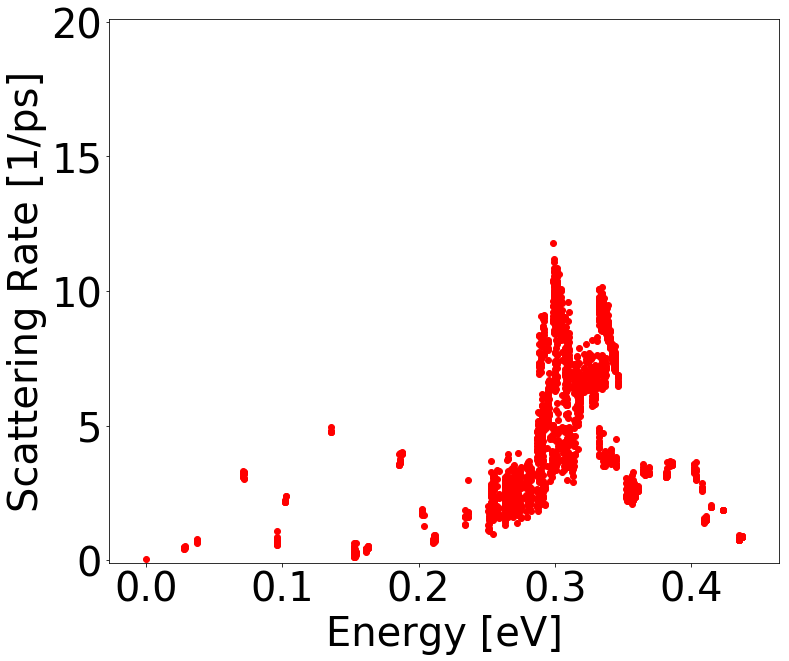

In [120]:
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 40})
plt.rcParams.update({'lines.linewidth': 3.5})

fig = plt.figure(figsize=(12,10))
ax = plt.gca()


plt.scatter((enk_df['energy [Ryd]'].values-enk_df['energy [Ryd]'].min())*13.6056980659,(abs_scattering_array+ems_scattering_array),c = 'Red')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('Scattering Rate [1/ps]')
plt.xlabel('Energy [eV]')
#plt.legend()
plt.ylim((-0.1,20.1))
plt.show()
fig.savefig('test.png', bbox_inches='tight')

In [123]:
len(full_g_df)

15709216

In [130]:
np.sum(full_g_df['k_en [eV]'] > (full_g_df['k_en [eV]'].min()+ 0.25))

15586794

## Data validation (Peishi Updated: 4/30)

In [110]:
def plot_bandstructure(kpts, enk): 
    '''Plots electron bandstructure. 
    
    Path is hardcoded for FCC unit cell. Currently just plotting Gamma-L and Gamma-X 
    
    Parameters: 
    ------------ 
    kpts : dataframe containing 
        k_inds : vector_like, shape (n,1) 
        Index of k point 

        'kx [1/A]' : vector_like, shape (n,1) 
        x-coordinate in Cartesian momentum space     

        'ky [1/A]' : vector_like, shape (n,1) 
        y-coordinate in Cartesian momentum space 

        'kz [1/A]' : vector_like, shape (n,1) 
        z-coordinate in Cartesian momentum space 

    enk : dataframe containing 
        k_inds : vector_like, shape (n,1) 
        Index of k point 

        band_inds : vector_like, shape (n,1) 
        Band index 

        energy [Ryd] : vector_like, shape (n,1) 
        Energy associated with k point in Rydberg units 

    Returns: 
    --------- 
    No variable returns. Just plots the dispersion  
    '''
    
    # Lattice constant and reciprocal lattice vectors 
    # b1 = 2 pi/a (kx - ky + kz) 
    # b2 = 2 pi/a (kx + ky - kz) 
    # b3 = 2 pi/a (-kx + ky + kz) 
    a = 5.556 #[A] 
    b1 = (2*np.pi/a) * np.array([1, -1, 1]) 
    b2 = (2*np.pi/a) * np.array([1, 1, -1]) 
    b3 = (2*np.pi/a) * np.array([-1, 1, 1]) 

    # L point in BZ is given by 0.5*b1 + 0.5*b2 + 0.5*b3 
    # X point in BZ is given by 0.5*b2 + 0.5*b3 
    lpoint = 0.5 * (b1 + b2 + b3) 
    xpoint = 0.5 * (b2 + b3) 

    # We can find kpoints along a path just by considering a dot product with lpoint and xpoint vectors. 
    # Any kpoints with angle smaller than some tolerance are considered on the path and we can plot their corresponding frequencies 
    deg2rad = 2*np.pi/360 
    ang_tol = 1 * deg2rad  # 1 degree in radians 

    enkonly = np.array(enk['energy [Ryd]'])[:, np.newaxis] 
    kptsonly = np.array(kpts[['kx [1/A]', 'ky [1/A]', 'kz [1/A]']]) / (2*np.pi/a) 
    kptsmag = np.linalg.norm(kptsonly, axis=1)[:, np.newaxis] 

    dot_l = np.zeros(len(kpts))
    dot_x = np.zeros(len(kpts))

    # Separate assignment for gamma point to avoid divide by zero error
    nongamma = kptsmag!=0
    dot_l[np.squeeze(nongamma)] = np.divide(np.dot(kptsonly, lpoint[:, np.newaxis])[nongamma], kptsmag[nongamma]) / np.linalg.norm(lpoint) 
    dot_x[np.squeeze(nongamma)] = np.divide(np.dot(kptsonly, xpoint[:, np.newaxis])[nongamma], kptsmag[nongamma]) / np.linalg.norm(xpoint) 
    dot_l[np.squeeze(kptsmag==0)] = 0 
    dot_x[np.squeeze(kptsmag==0)] = 0 

    lpath = np.logical_or(np.arccos(dot_l) < ang_tol, np.squeeze(kptsmag == 0))
    xpath = np.logical_or(np.arccos(dot_x) < ang_tol, np.squeeze(kptsmag == 0))

    plt.figure() 
    plt.plot(kptsmag[lpath], enkonly[lpath], '.') 
    plt.plot(-1*kptsmag[xpath], enkonly[xpath], '.') 
    plt.xlabel('k magnitude') 
    plt.ylabel('Energy in Ry')
    plt.show()

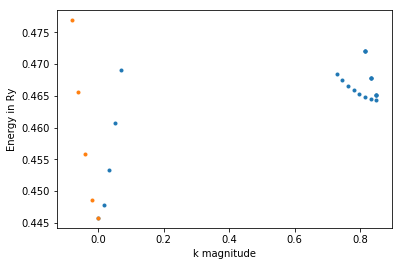

In [111]:
plot_bandstructure(cart_kpts_df, enk_df)

(21080, 3)
(21080, 1)
(21080, 6)


/home/peishi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning:

invalid value encountered in arccos

/home/peishi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning:

invalid value encountered in less



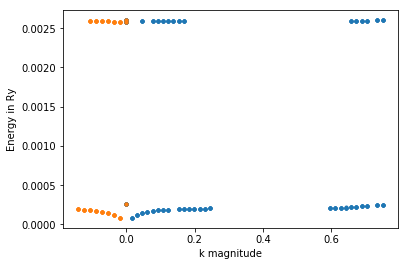

In [112]:
# plot_bandstructure(edit_cart_qpts_df, enq_df)
kpts = cart_kpts_df
enk = enk_df

kpts = edit_cart_qpts_df
enk = enq_df

a = 5.556 #[A] 
b1 = (2*np.pi/a) * np.array([1, -1, 1]) 
b2 = (2*np.pi/a) * np.array([1, 1, -1]) 
b3 = (2*np.pi/a) * np.array([-1, 1, 1]) 

# L point in BZ is given by 0.5*b1 + 0.5*b2 + 0.5*b3 
# X point in BZ is given by 0.5*b2 + 0.5*b3 
lpoint = 0.5 * (b1 + b2 + b3) 
xpoint = 0.5 * (b2 + b3) 

# We can find kpoints along a path just by considering a dot product with lpoint and xpoint vectors. 
# Any kpoints with angle smaller than some tolerance are considered on the path and we can plot their corresponding frequencies 
deg2rad = 2*np.pi/360 
ang_tol = 1 * deg2rad  # 1 degree in radians 

kptsonly = np.array(kpts[['kx [1/A]', 'ky [1/A]', 'kz [1/A]']]) / (2*np.pi/a) 
kptsmag = np.linalg.norm(kptsonly, axis=1)[:, np.newaxis] 

print(kptsonly.shape)
print(kptsmag.shape)

dot_l = np.zeros(len(kpts))
dot_x = np.zeros(len(kpts))

# Separate assignment for gamma point to avoid divide by zero error
nongamma = kptsmag!=0
dot_l[np.squeeze(nongamma)] = np.divide(np.dot(kptsonly, lpoint[:, np.newaxis])[nongamma], kptsmag[nongamma]) / np.linalg.norm(lpoint) 
dot_x[np.squeeze(nongamma)] = np.divide(np.dot(kptsonly, xpoint[:, np.newaxis])[nongamma], kptsmag[nongamma]) / np.linalg.norm(xpoint) 
dot_l[np.squeeze(kptsmag==0)] = 0 
dot_x[np.squeeze(kptsmag==0)] = 0 

lpath = np.logical_or(np.arccos(dot_l) < ang_tol, np.squeeze(kptsmag == 0))
xpath = np.logical_or(np.arccos(dot_x) < ang_tol, np.squeeze(kptsmag == 0))

# Need to reshape the energy dataframe for easy plotting if there are multiple bands
enk_ra = np.array(enk.iloc[:,:])
enk_ra.sort(axis=0)
nk = int(np.max(enk_ra[:, 0]))  # nk = number of kpts = highest kpts index
if np.mod(len(enk_ra), nk) != 0:
    exit('Something is wack with the number of bands and kpoints in the array')
else:
    nb = int(len(enk_ra) / nk)
enkonly = enk_ra[:, 2]
enk_by_band = np.reshape(enkonly, (nk, nb), order='C')

print(enk_by_band.shape)

plt.figure()
for b in range(nb):
    plt.plot(kptsmag[lpath], enk_by_band[lpath, b], '.', color='C0') 
    plt.plot(-1*kptsmag[xpath], enk_by_band[xpath, b], '.', color='C1') 
plt.xlabel('k magnitude') 
plt.ylabel('Energy in Ry')
plt.show()